# GRU-D를 사용해보기 전 LSTM으로 우선 모델링 테스트
- 결측치 대체방법에 따라 LSTM 성능 비교

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import csv
from tqdm import tqdm

In [2]:
# import data
df = pd.read_csv('00_df.csv', index_col=0)
pre_df = pd.read_csv('01_pre_df.csv', index_col=0)

In [3]:
df.shape   # (783926, 41)

(783926, 41)

In [4]:
pre_df.shape   # (783926, 37)

(783926, 37)

In [5]:
# import list data

data_length_per_person = []
data_length_per_person_sum = []

with open('data_length_per_person.csv', 'r', encoding='utf-8') as f:
    rdr = csv.reader(f)
    for para in rdr:
        for i in para:
            data_length_per_person.append(int(i))


with open('data_length_per_person_sum.csv', 'r', encoding='utf-8') as f:
    rdr = csv.reader(f)
    for para in rdr:
        for i in para:
            data_length_per_person_sum.append(int(i))

In [6]:
len(data_length_per_person)   # 20169

20169

In [7]:
len(data_length_per_person_sum)   # 20169

20169

## 결측치는 *1차적으로 통계적인 선형 모델로 대치*하고, <br>선형대치가 불가능한 column은 *2차로 전체 변수별 전체 평균값으로 대치*하여 진행

- 각 column의 평균 계산

우선 결측률 100% column(EtCO2)은 제거 하고 시작

In [68]:
df = df.drop('EtCO2', axis=1)
df.shape

(783926, 40)

In [69]:
cols = df.columns
cols.shape

(40,)

In [130]:
# 편한 계산을 위해 0 추가
data_length_per_person_sum.insert(0, 0)

In [92]:
# 전체 columns 별 평균 
mean_list = []

for col in cols:
    a = round(df[col].mean(), 1)
    mean_list.append(a)
    
if len(mean_list) == cols.shape[0]:
    print('정상적으로 columns 별 전체 평균이 추출되었습니다.')
else:
    print('error')

정상적으로 columns 별 전체 평균이 추출되었습니다.


In [93]:
# 환자별, columns 별 평균 
mean_list_per_person = []

s_i = 0
e_i = 1
for _ in tqdm(range(len(data_length_per_person_sum)-1)):
    s = data_length_per_person_sum[s_i]      # 0, 54, 77
    e = data_length_per_person_sum[e_i]      # 54, 77, 125

    temporary = []
    for col in cols:    
        temporary.append(round(df[col][s:e].mean(), 1))
    mean_list_per_person.append(temporary)
        
    s_i += 1
    e_i += 1

100%|██████████| 20168/20168 [01:01<00:00, 327.59it/s]


## 결측치 선행대치법 적용

In [94]:
# lstm_df 라는 결측 방법 적용 확인 대조군 전용 데이터 세트를 제작
# lstm_df = pd.DataFrame()

# s_i = 0
# e_i = 1

# for _ in tqdm(range(len(data_length_per_person_sum)-1)):
#     s = data_length_per_person_sum[s_i]      # 0, 54, 77
#     e = data_length_per_person_sum[e_i]      # 54, 77, 125
    
    
#     temp = pd.DataFrame(columns=cols)
#     for col in cols:
#         data = df[col][s:e]
#         data = data.interpolate(method="linear", limit_direction="both")
#         temp[col] = data

#     lstm_df = pd.concat([lstm_df, temp])
    
#     s_i += 1
#     e_i += 1

In [142]:
lstm_df.shape   # (783926, 40)

(783926, 40)

In [ ]:
# 결측치 변동 내역을 확인하기 위해 저장
a = lstm_df.isnull().sum()

In [ ]:
# 결측치 여부 확인
lstm_df.loc[lstm_df["HR"].isnull()]

In [178]:
# 선행 대치법 적용

s_i = 0
e_i = 1

interpolated_mv_df = pd.DataFrame() 
    
for _ in tqdm(range(len(data_length_per_person_sum)-1)):
    s = data_length_per_person_sum[s_i]      # 0, 54, 77
    e = data_length_per_person_sum[e_i]      # 54, 77, 125
    
    temp = pd.DataFrame(columns=cols)
    for i, col in  enumerate(cols):
        data = df[col][s:e].fillna(mean_list_per_person[_][i])
        temp[col] = data
    
    interpolated_mv_df = pd.concat([interpolated_mv_df, temp])
    
    s_i += 1
    e_i += 1

100%|██████████| 20169/20169 [19:32<00:00, 17.20it/s]


In [188]:
interpolated_mv_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,101.6,91.5,36.80,126.8,87.30,NaN,24.8,20.7,46.5,0.30,...,10.2,NaN,327.5,83.14,0,NaN,NaN,-0.03,1,0
1,97.0,95.0,36.80,98.0,75.33,NaN,19.0,20.7,46.5,0.30,...,10.2,NaN,327.5,83.14,0,NaN,NaN,-0.03,2,0
2,89.0,99.0,36.80,122.0,86.00,NaN,22.0,20.7,46.5,0.30,...,10.2,NaN,327.5,83.14,0,NaN,NaN,-0.03,3,0
3,90.0,95.0,36.80,126.8,87.30,NaN,30.0,24.0,46.5,0.30,...,10.2,NaN,327.5,83.14,0,NaN,NaN,-0.03,4,0
4,103.0,88.5,36.80,122.0,91.33,NaN,24.5,20.7,46.5,0.28,...,10.2,NaN,327.5,83.14,0,NaN,NaN,-0.03,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783921,88.0,98.0,38.10,135.0,81.00,64.0,16.0,0.0,25.7,0.50,...,14.0,NaN,325.5,62.29,1,NaN,NaN,-0.03,31,1
783922,96.0,98.0,38.72,174.0,97.00,72.0,16.0,2.0,25.7,0.50,...,14.0,NaN,325.5,62.29,1,NaN,NaN,-0.03,32,1
783923,140.0,97.0,38.10,133.0,81.50,62.5,16.0,0.0,25.7,0.50,...,14.0,NaN,325.5,62.29,1,NaN,NaN,-0.03,33,1
783924,120.0,96.0,38.10,154.0,118.00,105.0,16.0,0.0,25.7,0.50,...,14.0,NaN,325.5,62.29,1,NaN,NaN,-0.03,34,1


In [74]:
# 초기 interpolated_mv_df 저장
# interpolated_mv_df.to_csv("02_interpolated_mv_df.csv", mode='w')

In [78]:
# import interpolated_mv_df
interpolated_mv_df = pd.read_csv('02_interpolated_mv_df.csv', index_col=0)

In [79]:
b = interpolated_mv_df.isnull().sum()

In [80]:
# 환자별 평균. 결측치에 대치한 후 변화 확인
for x, y in zip(a, b):
    if x != y:
        print(f'{x}에서 변화가 있습니다.')
        
# 변화 없음. 확인

NameError: name 'a' is not defined

In [95]:
non_mv_df = pd.DataFrame(columns=cols)

for i, col in enumerate(cols):
    data = interpolated_mv_df[col].fillna(mean_list[i])
    non_mv_df[col] = data

In [96]:
non_mv_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,101.6,91.5,36.80,126.8,87.30,60.0,24.8,20.7,46.5,0.30,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,1,0
1,97.0,95.0,36.80,98.0,75.33,60.0,19.0,20.7,46.5,0.30,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,2,0
2,89.0,99.0,36.80,122.0,86.00,60.0,22.0,20.7,46.5,0.30,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,3,0
3,90.0,95.0,36.80,126.8,87.30,60.0,30.0,24.0,46.5,0.30,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,4,0
4,103.0,88.5,36.80,122.0,91.33,60.0,24.5,20.7,46.5,0.28,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783921,88.0,98.0,38.10,135.0,81.00,64.0,16.0,0.0,25.7,0.50,...,14.0,292.3,325.5,62.29,1,0.5,0.5,-0.03,31,1
783922,96.0,98.0,38.72,174.0,97.00,72.0,16.0,2.0,25.7,0.50,...,14.0,292.3,325.5,62.29,1,0.5,0.5,-0.03,32,1
783923,140.0,97.0,38.10,133.0,81.50,62.5,16.0,0.0,25.7,0.50,...,14.0,292.3,325.5,62.29,1,0.5,0.5,-0.03,33,1
783924,120.0,96.0,38.10,154.0,118.00,105.0,16.0,0.0,25.7,0.50,...,14.0,292.3,325.5,62.29,1,0.5,0.5,-0.03,34,1


## > 결측치 없는 data_set 구성 완료

추가로 해줘야 하는 일이 있다. <br>LSTM 등 여러 시퀀스 모델에 데이터를 넣을 때에는 데이터의 규격을 동일하게 일치해주어야 한다. 물론 아닌 모델도 있을 것이다. 하지만 LSTM은 규격이 일정해야 함으로 최적의 규격을 찾아 반영한다.

In [104]:
print('최단 데이터 길이:',min(data_length_per_person))
print('최장 데이터 길이:',max(data_length_per_person))

최단 데이터 길이: 8
최장 데이터 길이: 336


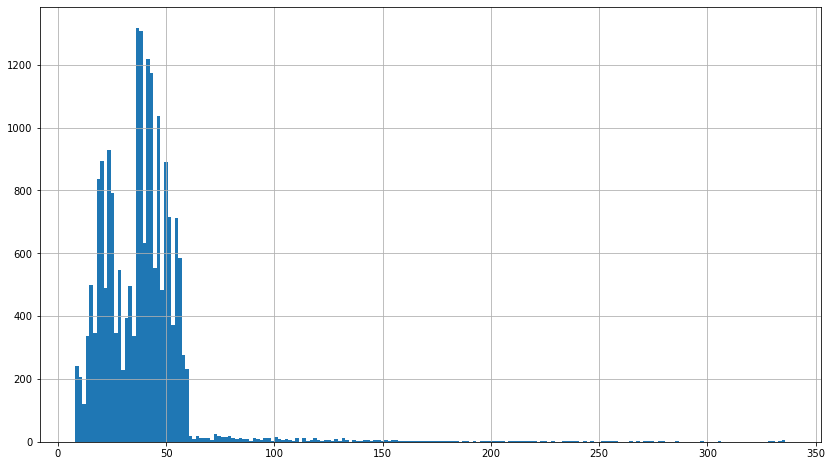

In [114]:
# fig, ax = plt.subplots(1,1, figsize=(15, 8))

plt.figure(figsize=(14, 8))
plt.hist(data_length_per_person, bins=200)
plt.grid()
plt.show()

# 여기서 중요한 관점!
입력되는 데이터의 길이를 설정할 것이다. 예를 들어 10개의 데이터를 기준으로 학습을 한다.는 것은 10시간 동안의 환자 정보를 기준으로 모델이 학습하게 된다는 것.
    
10시간동안의 환자 데이터를 분석한 모델을 가지고 예후를 예측하는데, 만약 2시간의 환자 데이터 밖에 없다면? 만약 5시간의 환자 데이터 밖에 없다면? 예측으 정확도에 영향을 미칠 것이다. 

그래프상 20 정도로 데이터로 자른다면 대부분을 포함할 수 있을 것 같아 비율을 확인.

In [122]:
count = 0
time = 20
for i in data_length_per_person:
    if i >= time:
        count += 1
        
print(count)
print(f'데이터 비율: {round(count/len(data_length_per_person), 2)}')

17585
데이터 비율: 0.87


꽤 많은 데이터를 포함할 수 있음을 확인

초기 3시간의 데이터를 보고 6시간 후의 패혈증 예측을 시도
time = 20의 데이터를 가지고 위의 예측을 시도한다면
>1. 1환자당 20시간(개)의 데이터만을 다루고
>2. 20시간에서 3시간의 데이터를 하나로 묶고 이후 6시간의 패혈증 예측을 시도한다면
>3. 1환자당 12개의 데이터를 학습할 수 있음

In [146]:
# 환자 1당 데이터의 개수를 20개로 제한 
# 20 이상의 데이터를 가지고 있는 환자는 일단 -1 인덱스부터 추출해 20개의 데이터로 제한
# > 데이터의 분포를 보면 패혈증이 아니다가, 발병했다고 체크되는 경우가 있음으로 
# > 데이터의 앞부분을 사용하게 된다면 패혈증이 아닌 상태의 데이터만 너무 많아 질 수 있기 때문에

# > 20개 미만의 데이터 세트(0.13%)는 drop


time = 20
s_i = 0
e_i = 1

equal_len_non_mv_df = pd.DataFrame(columns=cols)
    
for _ in tqdm(range(len(data_length_per_person_sum)-1)):
    s = data_length_per_person_sum[s_i]      # 0, 54, 77
    e = data_length_per_person_sum[e_i]      # 54, 77, 125

    if e - s + 1 > time:
        data = non_mv_df[e-time:e]

    equal_len_non_mv_df = pd.concat([equal_len_non_mv_df, data])
    
    s_i += 1
    e_i += 1

100%|██████████| 20169/20169 [09:07<00:00, 36.87it/s]


In [147]:
equal_len_non_mv_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
34,102.0,91.5,36.80,103.0,75.67,60.0,24.0,20.7,46.5,0.3,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,35,0
35,99.0,89.0,37.11,113.0,96.33,60.0,26.0,20.7,46.5,0.3,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,36,0
36,97.0,89.0,36.80,110.0,72.00,60.0,29.0,20.7,46.5,0.3,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,37,0
37,110.0,89.0,36.80,108.0,90.67,60.0,24.0,20.7,46.5,0.3,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,38,0
38,108.0,89.0,36.80,139.0,102.33,60.0,26.0,20.0,46.5,0.3,...,10.2,292.3,327.5,83.14,0,0.5,0.5,-0.03,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783921,88.0,98.0,38.10,135.0,81.00,64.0,16.0,0.0,25.7,0.5,...,14.0,292.3,325.5,62.29,1,0.5,0.5,-0.03,31,1
783922,96.0,98.0,38.72,174.0,97.00,72.0,16.0,2.0,25.7,0.5,...,14.0,292.3,325.5,62.29,1,0.5,0.5,-0.03,32,1
783923,140.0,97.0,38.10,133.0,81.50,62.5,16.0,0.0,25.7,0.5,...,14.0,292.3,325.5,62.29,1,0.5,0.5,-0.03,33,1
783924,120.0,96.0,38.10,154.0,118.00,105.0,16.0,0.0,25.7,0.5,...,14.0,292.3,325.5,62.29,1,0.5,0.5,-0.03,34,1


# LSTM 테스트를 위한 모델 구성

모델 학습

을 위한 데이터 세트 나누기 전 데이터 세트의 구성 파악

In [187]:
s = 0
e = 20

sepsis = 0
non_sepsis = 0
person_n = 0

while s < len(equal_len_non_mv_df):
    if equal_len_non_mv_df[s:e]['SepsisLabel'].sum() >= 1:
        sepsis += 1
    else: 
        non_sepsis += 1
        
    person_n += 1
    s += 20
    e += 20

In [188]:
print(sepsis + non_sepsis, '/  패혈증 데이터 :', sepsis, '/  non_패혈증 데이터 :', non_sepsis)

20169 /  패혈증 데이터 : 1415 /  non_패혈증 데이터 : 18754


time 20 미만의 데이터를 제외하였음에도 원본 데이터의 비율에 비슷한 데이터 세트 구축 확인

In [189]:
# sepsis와 non sepsis 구분

s = 0
e = 20

sepsis_df = pd.DataFrame(columns=cols)
non_sepsis_df = pd.DataFrame(columns=cols)

for _ in tqdm(range(person_n)):
    if equal_len_non_mv_df[s:e]['SepsisLabel'].sum() >= 1:
        data = equal_len_non_mv_df[s:e]
        sepsis_df = pd.concat([sepsis_df, data])
    else: 
        data = equal_len_non_mv_df[s:e]
        non_sepsis_df = pd.concat([non_sepsis_df, data])
        
    s += 20
    e += 20

100%|██████████| 20169/20169 [07:50<00:00, 42.84it/s]


In [586]:
print('sepsis: ', len(sepsis_df)//20 , "/ non_sepsis :", len(non_sepsis_df)//20)

sepsis:  1415 / non_sepsis : 18754


In [476]:
s_df = sepsis_df[['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']]

ns_df = non_sepsis_df[['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']]

In [592]:
for col in ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']:
    print(col, max(s_df[col]), min(s_df[col]), "//", max(s_df[col])-min(s_df[col]))

HR 192.0 33.0 // 159.0
O2Sat 100.0 20.0 // 80.0
Temp 40.56 32.3 // 8.260000000000005
SBP 241.0 41.0 // 200.0
MAP 298.0 22.0 // 276.0
DBP 189.0 24.0 // 165.0
Resp 66.0 2.5 // 63.5
BaseExcess 21.0 -18.0 // 39.0
HCO3 45.0 7.0 // 38.0
FiO2 1.0 0.2 // 0.8
pH 7.73 6.98 // 0.75
PaCO2 100.0 16.0 // 84.0
SaO2 100.0 29.0 // 71.0
AST 9507.0 4.0 // 9503.0
BUN 170.5 1.5 // 169.0
Alkalinephos 1117.0 7.0 // 1110.0
Calcium 15.6 4.2 // 11.399999999999999
Chloride 133.0 82.0 // 51.0
Creatinine 14.2 0.1 // 14.1
Bilirubin_direct 26.0 0.1 // 25.9
Glucose 753.0 35.0 // 718.0
Lactate 21.4 0.4 // 21.0
Magnesium 9.6 0.7 // 8.9
Phosphate 14.2 0.7 // 13.5
Potassium 8.8 2.4 // 6.4
Bilirubin_total 40.8 0.1 // 40.699999999999996
TroponinI 34.3 0.3 // 34.0
Hct 64.6 14.0 // 50.599999999999994
Hgb 20.3 4.8 // 15.5
PTT 150.0 18.8 // 131.2
WBC 174.7 0.1 // 174.6
Fibrinogen 1383.0 76.0 // 1307.0
Platelets 932.0 8.0 // 924.0
Age 88.9 18.44 // 70.46000000000001
Gender 1 0 // 1
Unit1 1.0 0.0 // 1.0
Unit2 1.0 0.0 // 1.0
Hosp

In [477]:
len(a)/20

1415.0

In [478]:
a = s_df.values.tolist()
len(a)/20

1415.0

In [479]:
s = 0
e = 20

s_temp = []
for _ in tqdm(range(int(len(a)/20))):
    for i in range(12):
        s_temp.append(a[s+i:s+i+3])
        
    s += 20
    e += 20        

100%|██████████| 1415/1415 [00:00<00:00, 95070.08it/s]


In [480]:
len(s_temp)

16980

In [481]:
b = ns_df.values.tolist()
len(b)/20

18754.0

In [482]:
s = 0
e = 20

ns_temp = []
for _ in tqdm(range(int(len(b)/20))):
    for i in range(12):
        ns_temp.append(b[s+i:s+i+3])
        
    s += 20
    e += 20        

100%|██████████| 18754/18754 [00:01<00:00, 17155.00it/s]


In [558]:
len(ns_temp)

225048

In [559]:
print(f'sepsis + nonSepsis: {len(s_temp)+len(ns_temp)}')

sepsis + nonSepsis: 242028


In [564]:
nx_train = ns_temp[:180038]
nx_val = ns_temp[180038:202543]
nx_test = ns_temp[202543:225048]

print(len(nx_train), len(nx_val), len(nx_test), len(nx_val) + len(nx_test)+ len(nx_train))

180038 22505 22505 225048


In [565]:
x_train = s_temp[:13584]
x_val = s_temp[13584: 15282]
x_test = s_temp[15282:16980]

print( len(x_train), len(x_val), len(x_test), len(x_val) + len(x_test)+ len(x_train))

13584 1698 1698 16980


In [566]:
y_train = [1]*len(x_train) + [0]*len(nx_train)
y_val = [1]*len(x_val) + [0]*len(nx_val)
y_test = [1]*len(x_test) + [0]*len(nx_test)

print(len(y_train), len(y_val), len(y_test), len(y_val) + len(y_test)+ len(y_train))

193622 24203 24203 242028


In [518]:
x_train = x_train + nx_train
x_val = x_val + nx_val
x_test = x_test + nx_test

print(len(x_train), len(x_val), len(x_test), len(x_val) + len(x_test)+ len(x_train))

193622 24203 24203 242028


In [549]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)


y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(193622, 3, 39) (193622,)
(24203, 3, 39) (24203,)
(24203, 3, 39) (24203,)


## 데이터 세트 구성 완료

In [523]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [583]:
hidden_units = 128

model = Sequential()
model.add(LSTM(hidden_units, activation='relu', input_shape=(3, 39)))
model.add(Dense(64))
model.add(Dense(1, activation='softmax'))

model.summary()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               86016     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 94,337
Trainable params: 94,337
Non-trainable params: 0
_________________________________________________________________


모델을 구성하였으니 학습과정을 설정

컴파일

모델을 학습시키기 이전에, compile 메소드를 통해서 학습 방식에 대한 환경설정을 해야 합니다. 다음의 세 개의 인자를 입력으로 받습니다.

- 정규화기 (optimizer). rmsprp나 adagrad와 같은 기존의 정규화기에 대한 문자열 식별자 또는 Optimizer 클래스의 인스턴스를 사용할 수 있습니다.
- 손실 함수 (loss function). 모델이 최적화에 사용되는 목적 함수입니다. categorical_crossentropy 또는 mse와 같은 기존의 손실 함수의 문자열 식별자 또는 목적 함수를 사용할 수 있습니다. 참고: 손실
- 기준(metric) 리스트. 분류 문제에 대해서는 metrics=['accuracy']로 설정합니다. 기준은 문자열 식별자 또는 사용자 정의 기준 함수를 사용할 수 있습니다.

In [584]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [585]:
hist = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/5
213/213 [==============================] - 3s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/5
213/213 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/5
213/213 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4/5
213/213 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 5/5
213/213 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000


loss: nan에서 하이퍼 파라미터를 변경해도 변화가 없어 데이터의 편향이 큰 것을 원인으로 파악(sepsis 0.1: non_sepsis 0.9)

데이터 비율을 1:1로 맞추어 다시 진행

In [562]:
len(x_train)

13584

In [567]:
y_train = [1]*len(x_train) + [0]*len(x_train)
y_val = [1]*len(x_val) + [0]*len(x_val)
y_test = [1]*len(x_test) + [0]*len(x_test)

print(len(y_train), len(y_val), len(y_test), len(y_val) + len(y_test)+ len(y_train))

27168 3396 3396 33960


In [568]:
x_train = x_train + nx_train[:len(x_train)]
x_val = x_val + nx_val[:len(x_val)]
x_test = x_test + nx_test[:len(x_test)]

print(len(x_train), len(x_val), len(x_test), len(x_val) + len(x_test)+ len(x_train))

27168 3396 3396 33960


In [569]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [571]:
hist = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_data=(x_val, y_val))

Epoch 1/5
2717/2717 [==============================] - 9s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/5
2717/2717 [==============================] - 7s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/5
2717/2717 [==============================] - 7s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/5
2717/2717 [==============================] - 7s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/5
2717/2717 [==============================] - 7s 3ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000


데이터 세트를 동일하게 맞추어 진행하여도 학습이 되지 않음.

In [578]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [593]:
hist = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/10
213/213 [==============================] - 2s 11ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/10
213/213 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/10
213/213 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4/10
213/213 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 5/10
213/213 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 6/10
213/213 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 7/10
213/213 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.